In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score

from scipy import stats

In [198]:
# import data
df = pd.read_csv('../data/results_matrix.csv')
# subset to columns included in the plot
# Combine the two dataframes for easy plotting
# subset to desired models
# rename models for plotting
df.replace({'base_nli': 'NLI Base', 
            'large_nli':'NLI Large', 
            'base_debate':'DEBATE Base',
            'llama':'Llama 3.1',
            'large_debate':'DEBATE Large',
            'sonnet':'Claude 3.5',
            'base_modern': 'DEBATE Base (MB)',
            'large_modern': 'DEBATE Large (MB)',
            'event extraction': 'Events',
            'hatespeech and toxicity':'Hatespeech',
            'stance detection':'Stance',
            'topic classification':'Topic'
           }, inplace = True)

# drop for jobtalk slides
df = df[~df['Model'].str.contains('(MB)')]
df.reset_index(drop = True, inplace = True)

/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_93322/778895968.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['Model'].str.contains('(MB)')]


/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_93322/20634837.py:16: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=metric,


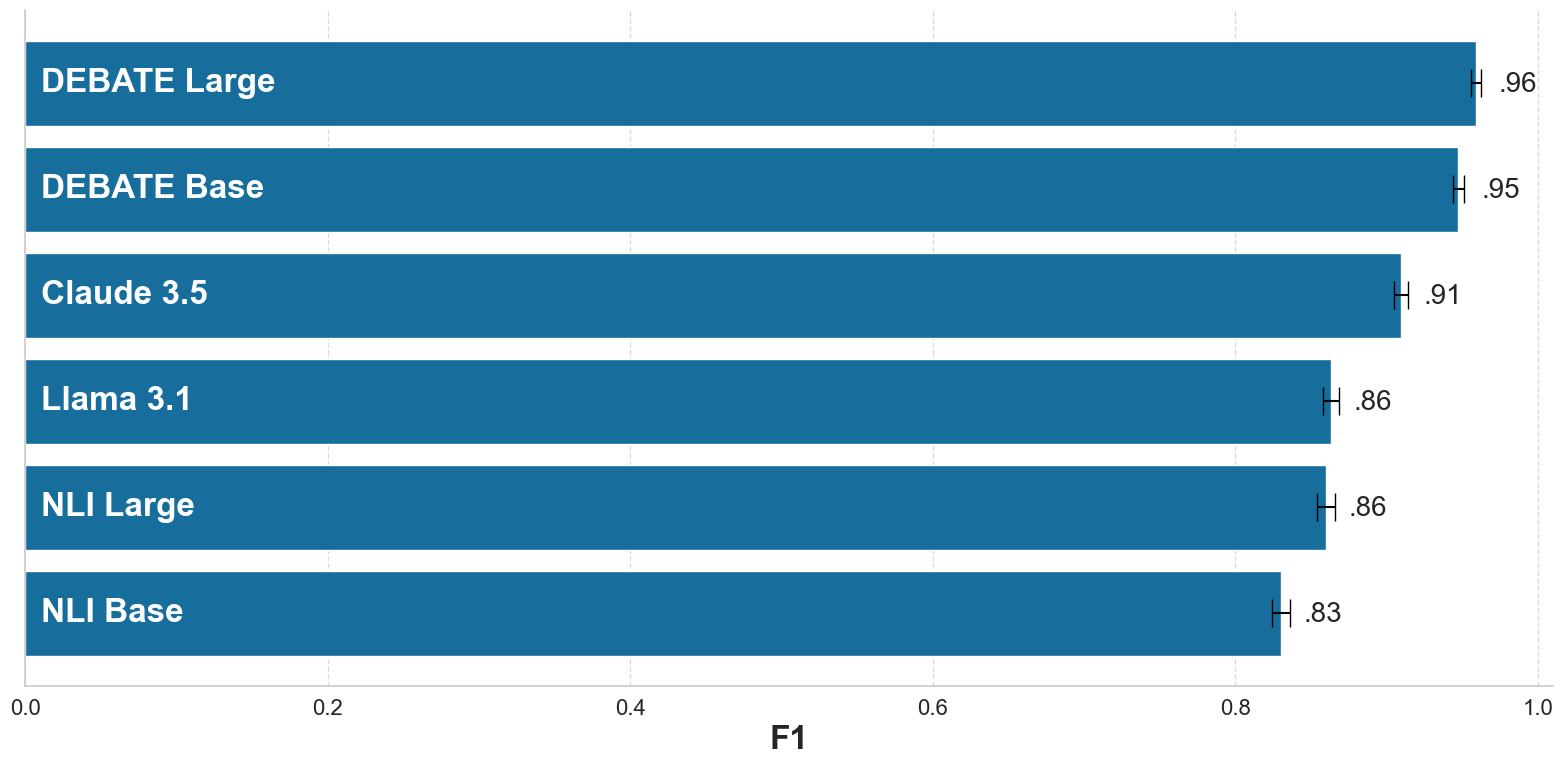

In [211]:
metric = 'F1'
task = 'overall'

data = df[df['Task'] == task].copy()
# Sort the dataframe by MCC values in descending order
data = data.sort_values(metric, ascending=False)
data.reset_index(drop = True, inplace = True)
# Set the style and font scale
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

custom_palette = sns.color_palette("colorblind", len(data['Task'].unique()))

# Create the bar plot
plt.figure(figsize=(16, 8))
ax = sns.barplot(x=metric, 
                 y='Model', 
                 data=data, 
                 hue = metric,
                 palette=custom_palette,
                 orient='h')

# Add error bars
plt.errorbar(x=data[metric], y=data.index, xerr=data[metric + '_SE']*1.96,
             fmt='none', ecolor='black', capsize=10)

# Add MCC values at the end of bars
for i, v in enumerate(data[metric]):
    ax.text(v+.015, i+.02, f'{v:.2f}'.lstrip('0'), va='center', fontsize=20)

for i, label in enumerate(data['Model']):
    ax.text(0.01, i, label, va='center', ha='left', color='white', fontweight='bold', fontsize=24)

# Customize the plot
plt.xlabel(metric, fontweight='bold', fontsize=24)
plt.ylabel('')  # Remove y-axis label
ax.set_yticklabels([])
# Increase font size of tick marks
plt.tick_params(axis='both', which='major', labelsize=16)

# Adjust the x-axis limit to accommodate the text
#plt.xlim(0, max(data['mcc']) * 1.1)

# Remove top and right spines
sns.despine(top=True, right=True)

# Remove vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='')
legend = plt.legend()
legend.remove()

# Show the plot
plt.tight_layout()
plt.savefig(r'../plots/test_overall_{}.png'.format(metric), dpi = 300)
plt.show()

# By Task

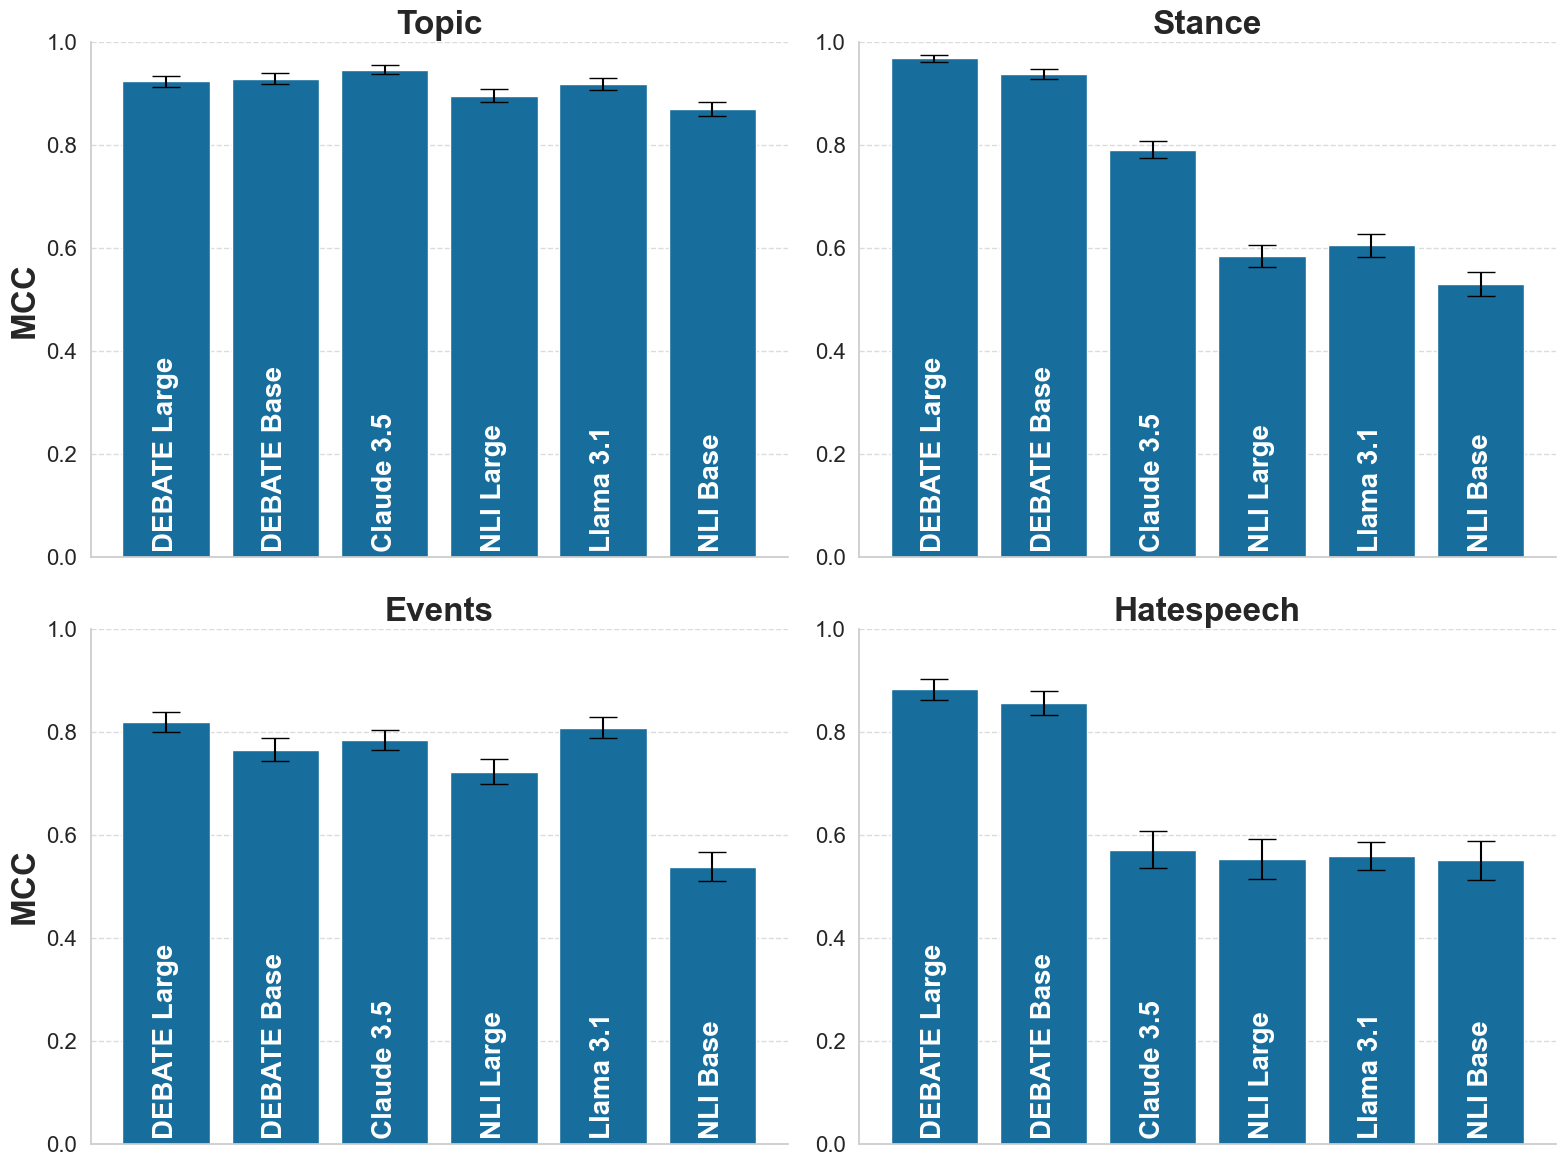

In [213]:
tasks = ['Topic', 'Stance', 'Events', 'Hatespeech']
metric = 'MCC'
data = df[df['Task'].isin(tasks)].copy()  # Create a copy to avoid SettingWithCopyWarning

modelorder = ["DEBATE Large", "DEBATE Base", "Claude 3.5", "NLI Large", "Llama 3.1", "NLI Base"]

data['Model'] = pd.Categorical(data['Model'], categories=modelorder, ordered=True)
data['Task'] = pd.Categorical(data['Task'], categories=tasks, ordered=True)
data = data.sort_values(['Task', 'Model'])
data.reset_index(drop=True, inplace=True)

# Set up the subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

# Get the first color from the colorblind palette
bar_color = sns.color_palette("colorblind")[0]

# Create a bar plot for each task
for i, task in enumerate(tasks):
    task_data = data[data['Task'] == task]
    
    # Create the bar plot
    barplot = sns.barplot(
        x="Model",
        y=metric,
        data=task_data,
        color=bar_color,
        errorbar=None,
        ax=axs[i]
    )
    
    # Add error bars and labels inside bars
    for j, (bar, lower, upper, model) in enumerate(zip(barplot.patches, task_data[metric + '_Lower'], task_data[metric + '_Upper'], task_data['Model'])):
        bar_x = bar.get_x() + bar.get_width() / 2
        bar_height = bar.get_height()
        
        # Add error bars
        axs[i].errorbar(
            x=bar_x,
            y=bar_height,
            yerr=[[(bar_height - lower)*1.96], [(upper - bar_height)*1.96]],
            fmt='none',
            capsize=10,
            color='black'
        )
        
        # Add label inside bar
        axs[i].text(bar_x, 0.01, model, ha='center', va='bottom', 
                    rotation=90, color='white', fontweight='bold', fontsize=20)
    
    # Customize each subplot
    axs[i].set_title(task, fontsize=24, fontweight = 'bold')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(metric if i % 2 == 0 else '', fontsize = 24, fontweight = 'bold')  # Add y-label only for left subplots
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    axs[i].set_xticks([])  # Remove x-axis ticks
    sns.despine(ax=axs[i], top=True, right=True, bottom=False)  # Remove bottom spine
    axs[i].grid(axis='y', which='both', linestyle='--', alpha=0.7)
    
    # Set y-axis limit to 1
    axs[i].set_ylim(0, 1)
    
    # Only show y-ticks for left subplots
    #if i % 2 != 0:
    #    axs[i].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.savefig(r'../plots/test_tasks_{}.png'.format(metric), dpi = 300)
# Show the plot
plt.show()


# By Dataset

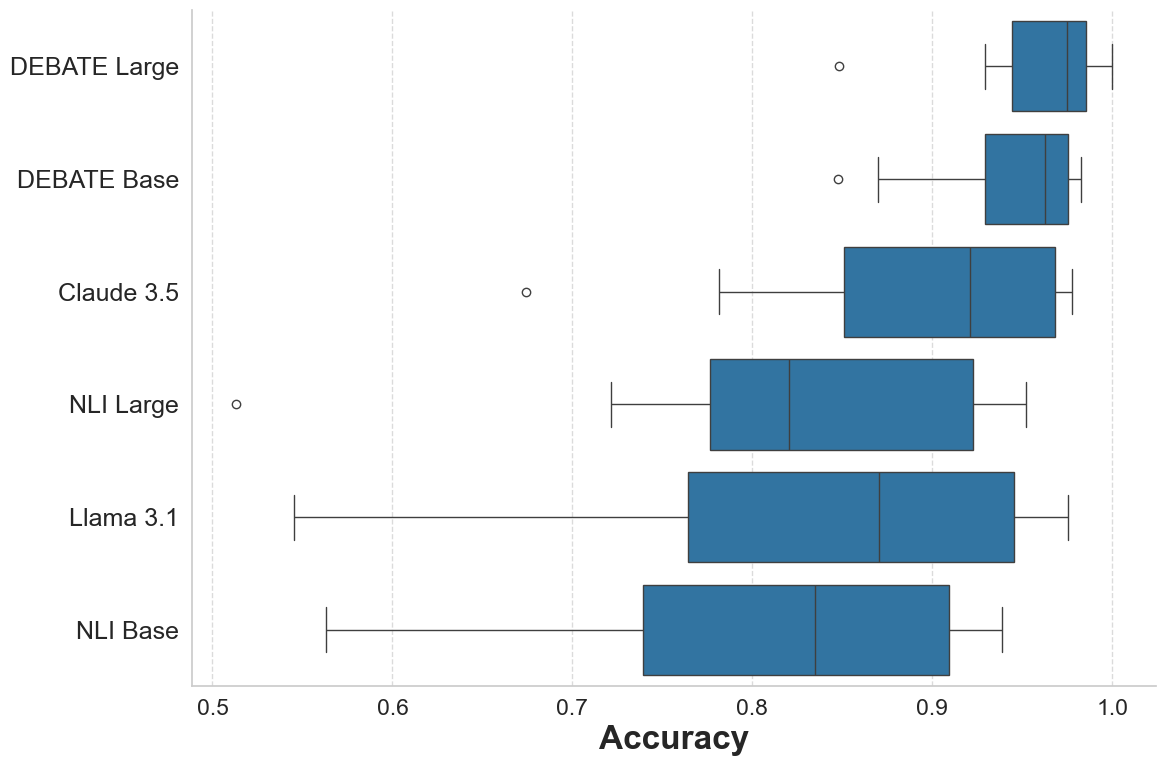

In [204]:
metric = 'Accuracy'
tasks = ['PoliStance_Affect', 'PoliStance_Affect_QT',
       'acled_event_entailment', 'argument_quality_ranking_entailment',
       'bill_summary_entailment', 'dehumanizing_hatespeech_entailment',
       'dem_rep_party_platform_topics', 'ibm_claimstance_entailment',
       'ibm_claimstance_topic_entailment', 'polistance_issue_tweets',
       'scad_event_entailment', 'targeted_hatespeech_entailment',
       'violent_hatespeech_entailment']

modelorder = ["DEBATE Large", "DEBATE Base", "Claude 3.5", "NLI Large", "Llama 3.1", "NLI Base"]

data = df[df['Task'].isin(tasks)].copy()
data['Model'] = pd.Categorical(data['Model'], categories=modelorder, ordered=True)
bar_color = sns.color_palette("colorblind")[0]

# Set the figure size for better visibility
plt.figure(figsize=(12, 8))

# Create the box plot
sns.boxplot(
    x=metric,           # X-axis
    y='Model',        # Y-axis
    data=data,         # Your DataFrame
    fill=bar_color  # Use a colorblind-friendly palette
)
sns.despine(top=True, right=True)
# Label the axes
plt.xlabel(metric, fontweight = 'bold', size = 24)
plt.ylabel('')
plt.tick_params(axis='y', which='major', labelsize=18)
plt.grid(axis='x', which='both', linestyle='--', alpha=0.7)
# Improve layout
plt.tight_layout()
plt.savefig(r'../plots/test_datasets_{}.png'.format(metric), dpi = 300)
# Show the plot
plt.show()

# Few Shot

In [299]:
df.groupby('n').agg({'accuracy': ['mean', calculate_ci]}).reset_index()

C:\Users\mikeb\AppData\Local\Temp\ipykernel_6788\2430319109.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))


n  accuracy                                          
            mean                              calculate_ci
0    0  0.862607                                (nan, nan)
1   10  0.871219  (0.8627173705766075, 0.8797206668538428)
2   25  0.877319     (0.872830310086265, 0.88180781427663)
3   50  0.873671  (0.8640810738959019, 0.8832601754587701)
4  100  0.880975  (0.8737419326407659, 0.8882082528388312)

In [60]:
df = pd.read_csv('motn_fewshot_large.csv')
df.groupby('n').mean()

,mcc,accuracy
n,,
0,0.588539,0.816645
10,0.758550,0.888661
25,0.745886,0.888258
50,0.774674,0.900831
100,0.804872,0.913958


In [57]:
fr = pd.read_csv('motn_fewshot_base.csv')
fr.groupby('n').mean()

,mcc,accuracy
n,,
0,0.560919,0.812320
10,0.708204,0.863176
25,0.727987,0.880289
50,0.757141,0.892322
100,0.785176,0.905113


C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3559709369.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))
C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3559709369.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))


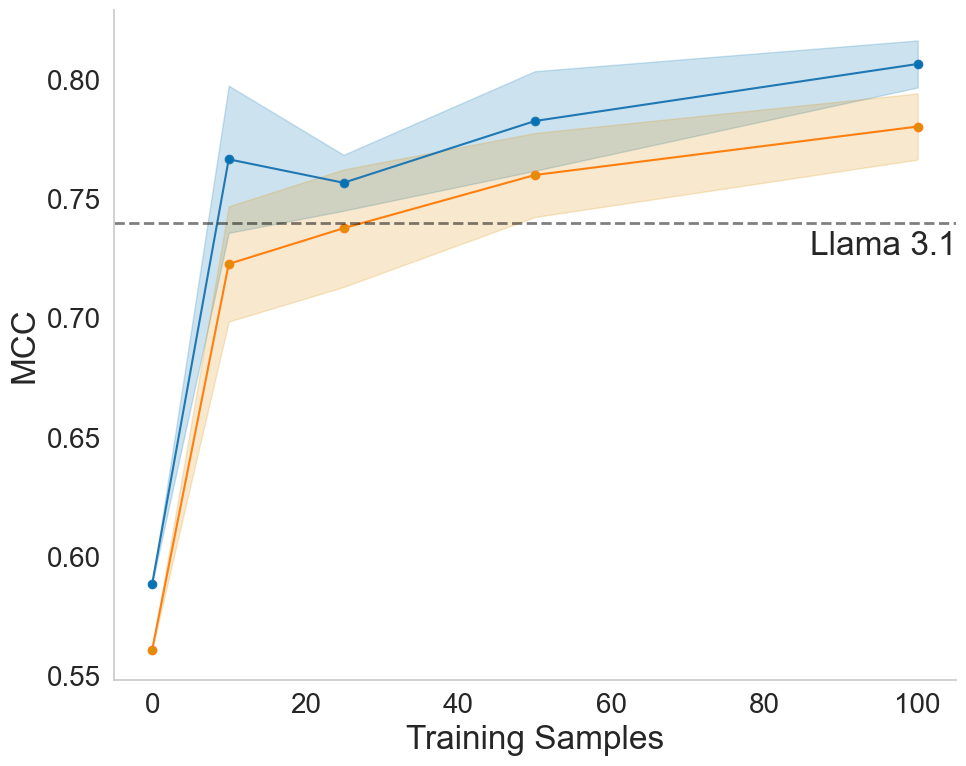

In [82]:
df = pd.read_csv('motn_fewshot_large2.csv')
fr = pd.read_csv('motn_fewshot_base2.csv')
textsize = 24
def calculate_ci(data):
    return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))

custom_palette = sns.color_palette("colorblind", 2)

# Group by 'n' and calculate mean MCC and confidence intervals for both dataframes
df_grouped = df.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
df_grouped.columns = df_grouped.columns.to_flat_index()
df_grouped.columns = ['n', 'mcc_mean', 'ci']
df_grouped['mcc_ci_low'] = [ci[0] for ci in df_grouped['ci']]
df_grouped['mcc_ci_high'] = [ci[1] for ci in df_grouped['ci']]
df_grouped.drop('ci', axis = 1, inplace = True)
df_grouped.fillna(df_grouped[df_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

fr_grouped = fr.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
fr_grouped.columns = fr_grouped.columns.to_flat_index()
fr_grouped.columns = ['n', 'mcc_mean', 'ci']
fr_grouped['mcc_ci_low'] = [ci[0] for ci in fr_grouped['ci']]
fr_grouped['mcc_ci_high'] = [ci[1] for ci in fr_grouped['ci']]
fr_grouped.drop('ci', axis = 1, inplace = True)
fr_grouped.fillna(fr_grouped[fr_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

# Create the plot
plt.figure(figsize=(10, 8))
#sns.set_style("whitegrid")

# Plot lines for both dataframes
plt.plot(df_grouped['n'], df_grouped['mcc_mean'], label='DEBATE Large', marker='o', markerfacecolor=custom_palette[0])
plt.plot(fr_grouped['n'], fr_grouped['mcc_mean'], label='DEBATE Base', marker='o', markerfacecolor=custom_palette[1])
sns.despine(top=True, right=True)
# Add confidence intervals
plt.fill_between(df_grouped['n'], df_grouped['mcc_ci_low'], df_grouped['mcc_ci_high'], alpha=0.2, color = custom_palette[0])
plt.fill_between(fr_grouped['n'], fr_grouped['mcc_ci_low'], fr_grouped['mcc_ci_high'], alpha=0.2, color=custom_palette[1])

plt.grid(axis='y', which='both', linestyle='', alpha=0.7)
plt.grid(axis='x', which='both', linestyle='', alpha=0.7)

#plt.axhline(y=0.66, color=custom_palette[0], linestyle='--', linewidth=2, alpha = 0.5)
plt.axhline(y=0.74, color='black', linestyle='--', linewidth=2, alpha = 0.5)

# Add annotations
#plt.text(plt.xlim()[1], 0.653, 'Supervised Transformer', va='center', ha='right')
plt.text(plt.xlim()[1], 0.73, 'Llama 3.1', va='center', ha='right', size = textsize)
plt.tick_params(axis = 'both', labelsize = textsize-4)

# Customize the plot
plt.xlabel('Training Samples', size = textsize)
plt.ylabel('MCC', size = textsize)
plt.title('')
#plt.legend(loc = 'lower right', fontsize = textsize)
plt.tight_layout()
plt.savefig('plots/fewshot_motn.png')
# Show the plot
plt.show()

In [52]:
fr.groupby('n').mean()

,mcc,accuracy
n,,
0,0.209142,0.742828
10,0.310338,0.762367
25,0.444210,0.793731
50,0.546057,0.830098
100,0.581413,0.841229


In [63]:
df.groupby('n').mean()

,mcc,accuracy
n,,
0,0.629658,0.862607
10,0.668466,0.870663
25,0.687157,0.876707
50,0.681714,0.875581
100,0.704320,0.886910


C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3448401063.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))
C:\Users\mikeb\AppData\Local\Temp\ipykernel_7496\3448401063.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))


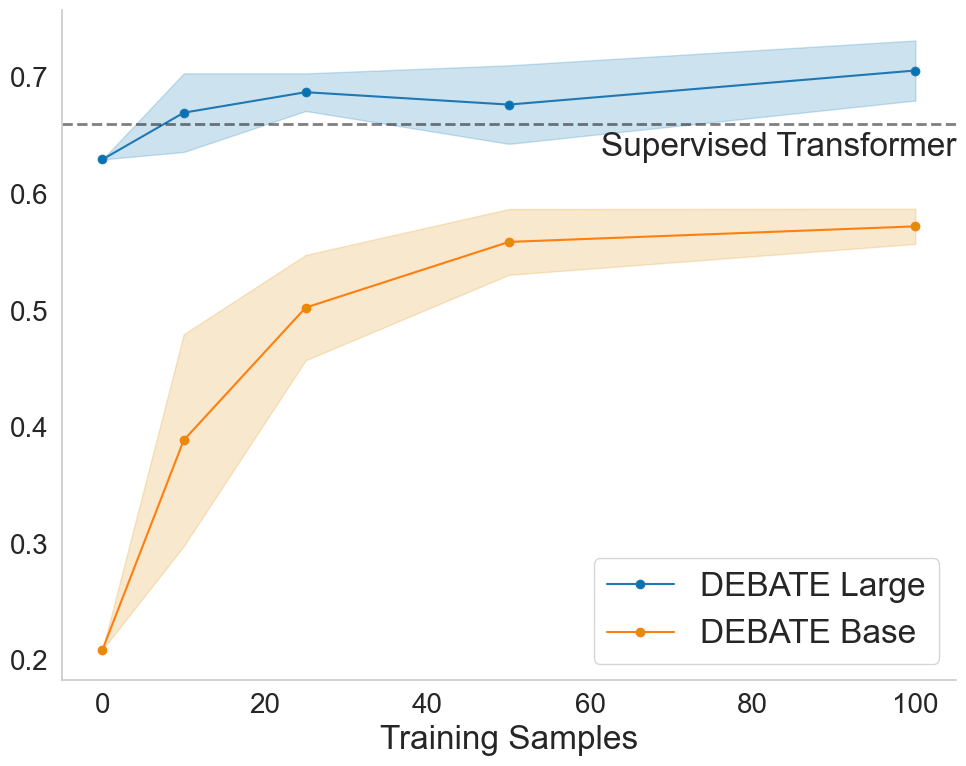

In [83]:
df = pd.read_csv('covid_fewshot_large2.csv')
fr = pd.read_csv('covid_fewshot_base.csv')
#df = pd.read_csv('motn_fewshot_base.csv')
#fr = pd.read_csv('motn_fewshot_large.csv')
textsize = 24
def calculate_ci(data):
    return stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))

custom_palette = sns.color_palette("colorblind", 2)

# Group by 'n' and calculate mean MCC and confidence intervals for both dataframes
df_grouped = df.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
df_grouped.columns = df_grouped.columns.to_flat_index()
df_grouped.columns = ['n', 'mcc_mean', 'ci']
df_grouped['mcc_ci_low'] = [ci[0] for ci in df_grouped['ci']]
df_grouped['mcc_ci_high'] = [ci[1] for ci in df_grouped['ci']]
df_grouped.drop('ci', axis = 1, inplace = True)
df_grouped.fillna(df_grouped[df_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

fr_grouped = fr.groupby('n').agg({'mcc': ['mean', calculate_ci]}).reset_index()
fr_grouped.columns = fr_grouped.columns.to_flat_index()
fr_grouped.columns = ['n', 'mcc_mean', 'ci']
fr_grouped['mcc_ci_low'] = [ci[0] for ci in fr_grouped['ci']]
fr_grouped['mcc_ci_high'] = [ci[1] for ci in fr_grouped['ci']]
fr_grouped.drop('ci', axis = 1, inplace = True)
fr_grouped.fillna(fr_grouped[fr_grouped['n'] == 0]['mcc_mean'][0], inplace = True)

# Create the plot
plt.figure(figsize=(10, 8))
#sns.set_style("whitegrid")

# Plot lines for both dataframes
plt.plot(df_grouped['n'], df_grouped['mcc_mean'], label='DEBATE Large', marker='o', markerfacecolor=custom_palette[0])
plt.plot(fr_grouped['n'], fr_grouped['mcc_mean'], label='DEBATE Base', marker='o', markerfacecolor=custom_palette[1])
sns.despine(top=True, right=True)
# Add confidence intervals
plt.fill_between(df_grouped['n'], df_grouped['mcc_ci_low'], df_grouped['mcc_ci_high'], alpha=0.2, color = custom_palette[0])
plt.fill_between(fr_grouped['n'], fr_grouped['mcc_ci_low'], fr_grouped['mcc_ci_high'], alpha=0.2, color=custom_palette[1])

plt.grid(axis='y', which='both', linestyle='', alpha=0.7)
plt.grid(axis='x', which='both', linestyle='', alpha=0.7)

plt.axhline(y=0.66, color='black', linestyle='--', linewidth=2, alpha = 0.5)
#plt.axhline(y=0.74, color=custom_palette[1], linestyle='--', linewidth=2, alpha = 0.5)

# Add annotations
plt.text(plt.xlim()[1], 0.64, 'Supervised Transformer', va='center', ha='right', size = textsize)
plt.tick_params(axis = 'both', labelsize = textsize-4)

# Customize the plot
plt.xlabel('Training Samples', size = textsize)
plt.ylabel('', size = textsize)
plt.title('')
plt.legend(loc = 'lower right', fontsize = textsize)
plt.tight_layout()
plt.savefig('plots/fewshot_covid.png')
# Show the plot
plt.show()

# Timing

In [249]:
df = pd.read_csv('../data/mps_timing.csv')

df['Model'].replace({'Political_DEBATE_base_v1.0': 'DEBATE Base',
       'Political_DEBATE_ModernBERT_base_v1.0': 'DEBATE Base (MB)',
       'Political_DEBATE_large_v1.0': 'DEBATE Large',
       'Political_DEBATE_ModernBERT_large_v1.0': 'DEBATE Large (MB)',
       'Meta-Llama-3.1-8B-Instruct': 'Llama 3.1 8B'}, inplace = True)

# temp data for building the plot
df2 = df.copy()
df2['Hardware'] = '3090'

df3 = df.copy()
df3['Hardware'] = 't4'

df4 = df.copy()
df4['Hardware'] = '9900x'
df = pd.concat([df, df2, df3, df4]).fillna(0)
df.reset_index(drop=True, inplace = True)

df['DPS_Lower'] = df['DPS'] - df['DPS_SE']

df['DPS_Upper'] = df['DPS'] + df['DPS_SE']

/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_93322/482932258.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Model'].replace({'Political_DEBATE_base_v1.0': 'DEBATE Base',


In [250]:
df.replace({'mps': 'Apple M3', 't4':'Tesla T4 GPU', '3090':'RTX 3090', '9900x':'Ryzen 9900x'}, inplace = True)

In [252]:
data

,Model,Hardware,Time,Time_SE,DPS,DPS_SE,DPS_Lower,DPS_Upper
0,DEBATE Base,Apple M3,32.423780,0.065819,154.207807,0.311828,153.895980,154.519635
2,DEBATE Large,Apple M3,82.668971,0.221989,60.482185,0.162230,60.319956,60.644415
4,Llama 3.1 8B,Apple M3,2219.904322,0.000000,2.252349,0.000000,2.252349,2.252349
5,DEBATE Base,RTX 3090,32.423780,0.065819,154.207807,0.311828,153.895980,154.519635
7,DEBATE Large,RTX 3090,82.668971,0.221989,60.482185,0.162230,60.319956,60.644415
9,Llama 3.1 8B,RTX 3090,2219.904322,0.000000,2.252349,0.000000,2.252349,2.252349
10,DEBATE Base,Tesla T4 GPU,32.423780,0.065819,154.207807,0.311828,153.895980,154.519635
12,DEBATE Large,Tesla T4 GPU,82.668971,0.221989,60.482185,0.162230,60.319956,60.644415
14,Llama 3.1 8B,Tesla T4 GPU,2219.904322,0.000000,2.252349,0.000000,2.252349,2.252349
15,DEBATE Base,Ryzen 9900x,32.423780,0.065819,154.207807,0.311828,153.895980,154.519635


<Figure size 1000x600 with 0 Axes>

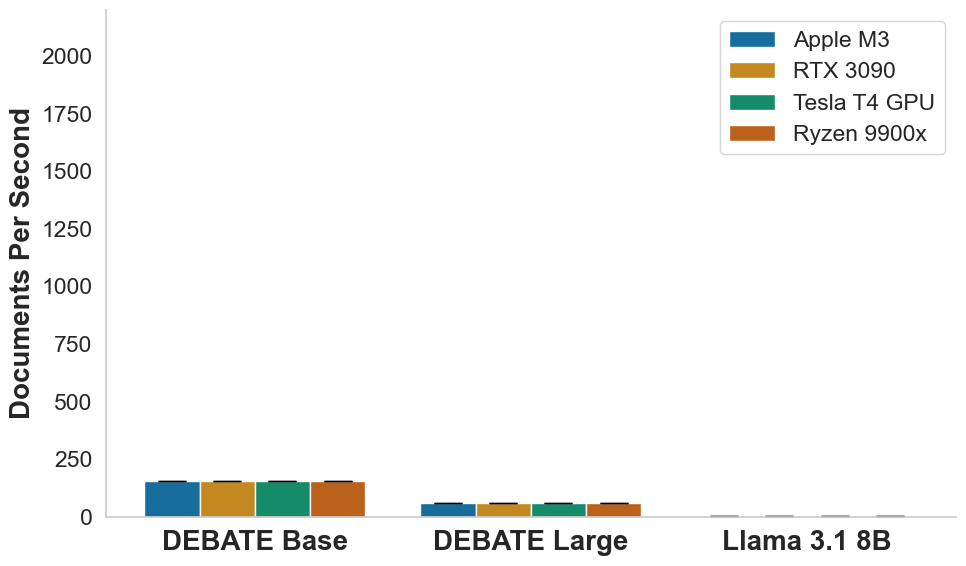

In [255]:
sns.set_palette("colorblind")

models = ['DEBATE Base', 'DEBATE Large', 'Llama 3.1 8B']
data = df[df['Model'].isin(models)]

# Create a grouped bar plot
plt.figure(figsize=(10, 6))

# Plot the bars
plt.figure(figsize=(10, 6))

# Plot the bars
barplot = sns.barplot(x='Model', y='DPS', hue='Hardware', data=data)

# Add error bars
num_models = len(data['Model'].unique())  # Number of unique models
num_hardware = len(data['Hardware'].unique())  # Number of unique hardware types
bar_width = 0.8 / num_hardware  # Dynamically adjust bar width

for i, hardware in enumerate(data['Hardware'].unique()):
    subset = data[data['Hardware'] == hardware]
    # Calculate x positions for error bars
    x_positions = np.arange(num_models) + i * bar_width - (bar_width * (num_hardware - 1) / 2)
    plt.errorbar(
        x=x_positions,
        y=subset['DPS'],
        yerr=subset['DPS_SE'],
        fmt='none',
        color='black',
        capsize=10
    )

# Remove the X-axis label
plt.xlabel('')

# Make X-axis tick labels bold
plt.xticks(fontweight='bold', fontsize = 20)

# Make Y-axis label bold
plt.ylabel('Documents Per Second', fontweight='bold', fontsize = 20)
plt.ylim(0,2200)
# Remove the legend title
plt.legend(title='')

sns.despine()  # Remove top and right spines
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

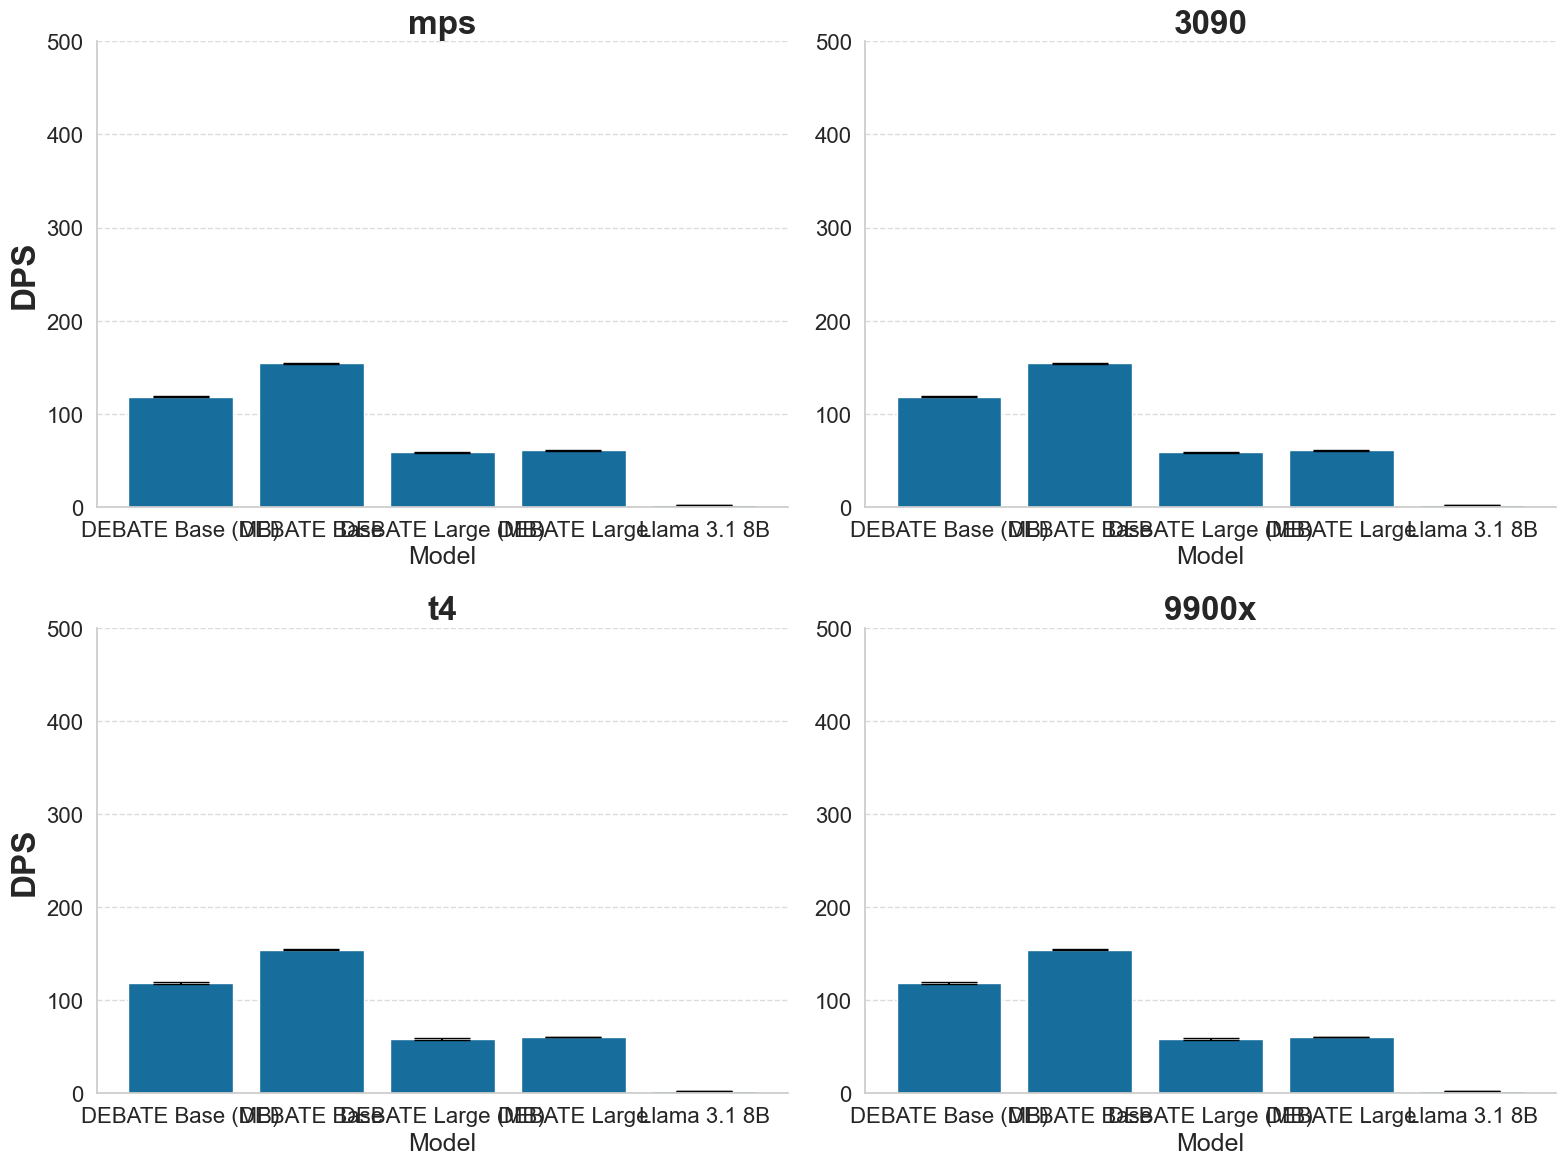

In [195]:
hardware = list(df['Hardware'].unique())
metric = 'DPS'
data = df[df['Hardware'].isin(hardware)].copy()  # Create a copy to avoid SettingWithCopyWarning

modelorder = ["DEBATE Base (MB)", "DEBATE Base", "DEBATE Large (MB)", "DEBATE Large", "Llama 3.1 8B"]

data['Model'] = pd.Categorical(data['Model'], categories=modelorder, ordered=True)
data['Hardware'] = pd.Categorical(data['Hardware'], categories=hardware, ordered=True)
data = data.sort_values(['Hardware', 'Model'])
data.reset_index(drop=True, inplace=True)

# Set up the subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

# Get the first color from the colorblind palette
bar_color = sns.color_palette("colorblind")[0]

# Create a bar plot for each task
for i, task in enumerate(hardware):
    task_data = data[data['Hardware'] == task]
    
    # Create the bar plot
    barplot = sns.barplot(
        x="Model",
        y=metric,
        data=task_data,
        color=bar_color,
        errorbar=None,
        ax=axs[i]
    )
    
    # Add error bars and labels inside bars
    for j, (bar, lower, upper, model) in enumerate(zip(barplot.patches, task_data[metric + '_Lower'], task_data[metric + '_Upper'], task_data['Model'])):
        bar_x = bar.get_x() + bar.get_width() / 2
        bar_height = bar.get_height()
        
        # Add error bars
        axs[i].errorbar(
            x=bar_x,
            y=bar_height,
            yerr=[[(bar_height - lower)*1.96], [(upper - bar_height)*1.96]],
            fmt='none',
            capsize=20,
            color='black'
        )
        
        # Add label inside bar
        #axs[i].text(bar_x, 0.01, model, ha='center', va='bottom', 
        #            rotation=90, color='white', fontweight='bold', fontsize=20)
    
    # Customize each subplot
    axs[i].set_title(task, fontsize=24, fontweight = 'bold')
    #axs[i].set_xlabel('')
    axs[i].set_ylabel(metric if i % 2 == 0 else '', fontsize = 24, fontweight = 'bold')  # Add y-label only for left subplots
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    #axs[i].tick_params(axis = 'x', rotation = 45)  # Remove x-axis ticks
    sns.despine(ax=axs[i], top=True, right=True, bottom=False)  # Remove bottom spine
    axs[i].grid(axis='y', which='both', linestyle='--', alpha=0.7)
    
    # Set y-axis limit to 1
    axs[i].set_ylim(0, 500)
    
    # Only show y-ticks for left subplots
    #if i % 2 != 0:
    #    axs[i].set_yticks([])

# Adjust layout
plt.tight_layout()
#plt.savefig(r'../plots/test_tasks_{}.png'.format(metric), dpi = 300)
# Show the plot
plt.show()
